In [17]:
import pandas as pd
import os
import shutil
from zipfile import ZipFile, BadZipFile
import json
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from sklearn.cluster import KMeans


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

print(np.__version__)

1.26.4


## IMPORT AND PREPROCESS DATA (scripts list)

In [18]:
metrics = pd.read_csv('metrics_attr.csv')

# Filter by Action Genre
metrics_action_clicker = metrics[(metrics['Main Genre'] == 'Action') & (metrics['Second Genre']== 'Clicker')]

# Check the filenames for collect
filenames_action_clicker = list(metrics_action_clicker['Name'])

In [19]:
def load_json_project(path_projectsb3):
    try:
        zip_file = ZipFile(path_projectsb3, "r")
        json_project = json.loads(zip_file.open("project.json").read())
        return json_project
    except BadZipFile:
        print('Bad zipfile')

def process(json_project):
    seq_num = 0
    dict_total_blocks = {}
    
    list_total_blocks = []

    for key, list_info in json_project.items():
        if key == "targets":
            for dict_target in list_info:
                target_name = dict_target.get('name')
                if target_name:
                    dict_total_blocks[target_name] = {}
                    dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                blocks = dict_target.get('blocks')
                if blocks:
                    for block_id, block_info in blocks.items():
                        if isinstance(block_info, dict):
                            topLevel = block_info.get('topLevel')
                            if topLevel:
                                seq_num += 1
                                dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                            opcode = block_info.get('opcode')
                            if opcode:
                                
                                dict_total_blocks[target_name][f'Seq_{seq_num}'].append(opcode)
                            list_total_blocks.append(block_info)
                            #dict_total_blocks[block_id] = block_info
    return dict_total_blocks

dict_total_blocks = {}
scripts = []
list_total_blocks = []
print(len(filenames_action_clicker))
for project in filenames_action_clicker:
    sb3_path = os.path.join('.','sb3_action_clicker',project)
    if os.path.isfile(sb3_path):
        print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for idx, block_list in seqs.items():
                if block_list != []:
                    scripts.append(" ".join(block_list))

#print(scripts)
for script in scripts:
    print(script + '\n')

88
Abby and Grace's project.sb3
Aji Jesu Game.sb3
Becca and Alana Climate change.sb3
Brendan and Hallel.sb3
Building wackamole in the city of Hainsboro.sb3
CARbon Killer.sb3
CO2 Crusher.sb3
CO2 Killer.sb3
CO2 fr.sb3
Car.sb3
Carbon Clicker_(2).sb3
Carbon Destroyer.sb3
Carbon Footprint project.sb3
Catch the CO2.sb3
Clara and Mira's Project.sb3
Class Project Sage and Nora.sb3
Climate Change - Caitlin & Irene.sb3
Climate Change Game_(9).sb3
Climate Change Project_(2).sb3
Climate Change With Cars and CO2.sb3
Climate Change and the CO2 Succa.sb3
Climate Clikerz.sb3
Climate Control.sb3
Climate change game!!!!.sb3
Climate change game.sb3
Climate change.sb3
Co2 Survival.sb3
David & Peter.sb3
Deforestation Game.sb3
Don't Get Burned!.sb3
Emily and haley Greenhouse effect.sb3
Eujin and Julia.sb3
Factory Game Thalia and Jehan.sb3
Factory Game remix.sb3
Farmer Sam and His Cows.sb3
Future C02.sb3
Garden Simulator 2k17.sb3
Global Warming Game.sb3
Greenhouse Gases Game.sb3
Guy+Sonia-Lower the Carbon!.s

## CREATION OF DATASET

In [20]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_sz= 2):
        super().__init__
        self.corpus = corpus
        self.window = window_sz
        self.vocab = list(set(token.lower() for sentence in self.corpus for token in sentence.split())) # set elimina dups y no mantiene el orden
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()

    def gen_dataset(self):
        # Metod for enventanado
        data = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            #print(text)
            for center_idx, center_word in enumerate(text):
                for offset in range(-self.window, self.window +1):
                    context_idx = center_idx + offset
                    if context_idx < 0 or context_idx >= len(text) or context_idx == center_idx: continue
                    context_word = text[context_idx]
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## DEFINE ARCHITECTURE AND IMPORT MODEL 

In [21]:
class SkipGram(nn.Module):
    def __init__(self, vocab_sz, embed_sz):
        super().__init__()
        self.embed_layer = nn.Linear(vocab_sz, embed_sz, bias = False)
        self.output_layer = nn.Linear(embed_sz, vocab_sz)

    def forward(self, x):
        return self.output_layer(self.embed_layer(x))

In [22]:
learning_rate = 0.0001

dataset = SkipGramData(scripts)
print(type(dataset.data))
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = SkipGram(len(dataset.vocab), embed_sz=300)
model.load_state_dict(torch.load('embedding_action_clicker.pth')['model_state_dict'])
model.eval()

embeddings = model.embed_layer.weight.detach().numpy()
print("Embed_layer weights:", embeddings)


<class 'list'>
Embed_layer weights: [[-0.5740669   1.3872908   0.41845173 ...  0.6725084  -0.2362035
   1.4916228 ]
 [ 0.2560746   1.0246533  -0.82214403 ... -1.3338214  -0.49737757
  -0.35142884]
 [ 0.45272565 -0.11868317 -0.58667916 ... -0.24329755 -0.6400827
  -0.0036138 ]
 ...
 [ 0.6878623   0.10762936  0.8402224  ...  0.21946248 -0.8447947
  -1.1589925 ]
 [-0.8494934   1.6756341  -0.5090331  ...  1.4407841   0.5751644
   1.3421383 ]
 [ 0.5631632  -1.0606579   0.7684212  ...  0.34494537  0.6735015
  -0.2662916 ]]


## PLOTING RESULTS

In [23]:
def plot_embeddings(embedings, word2idx):
    num_samples = len(word2idx)
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    plt.figure(figsize=(30,20))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx, 1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5,2), 
                    textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualized using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel(True)
    plt.show()
    plt.savefig('embedding_action_clicker.png', format='png')

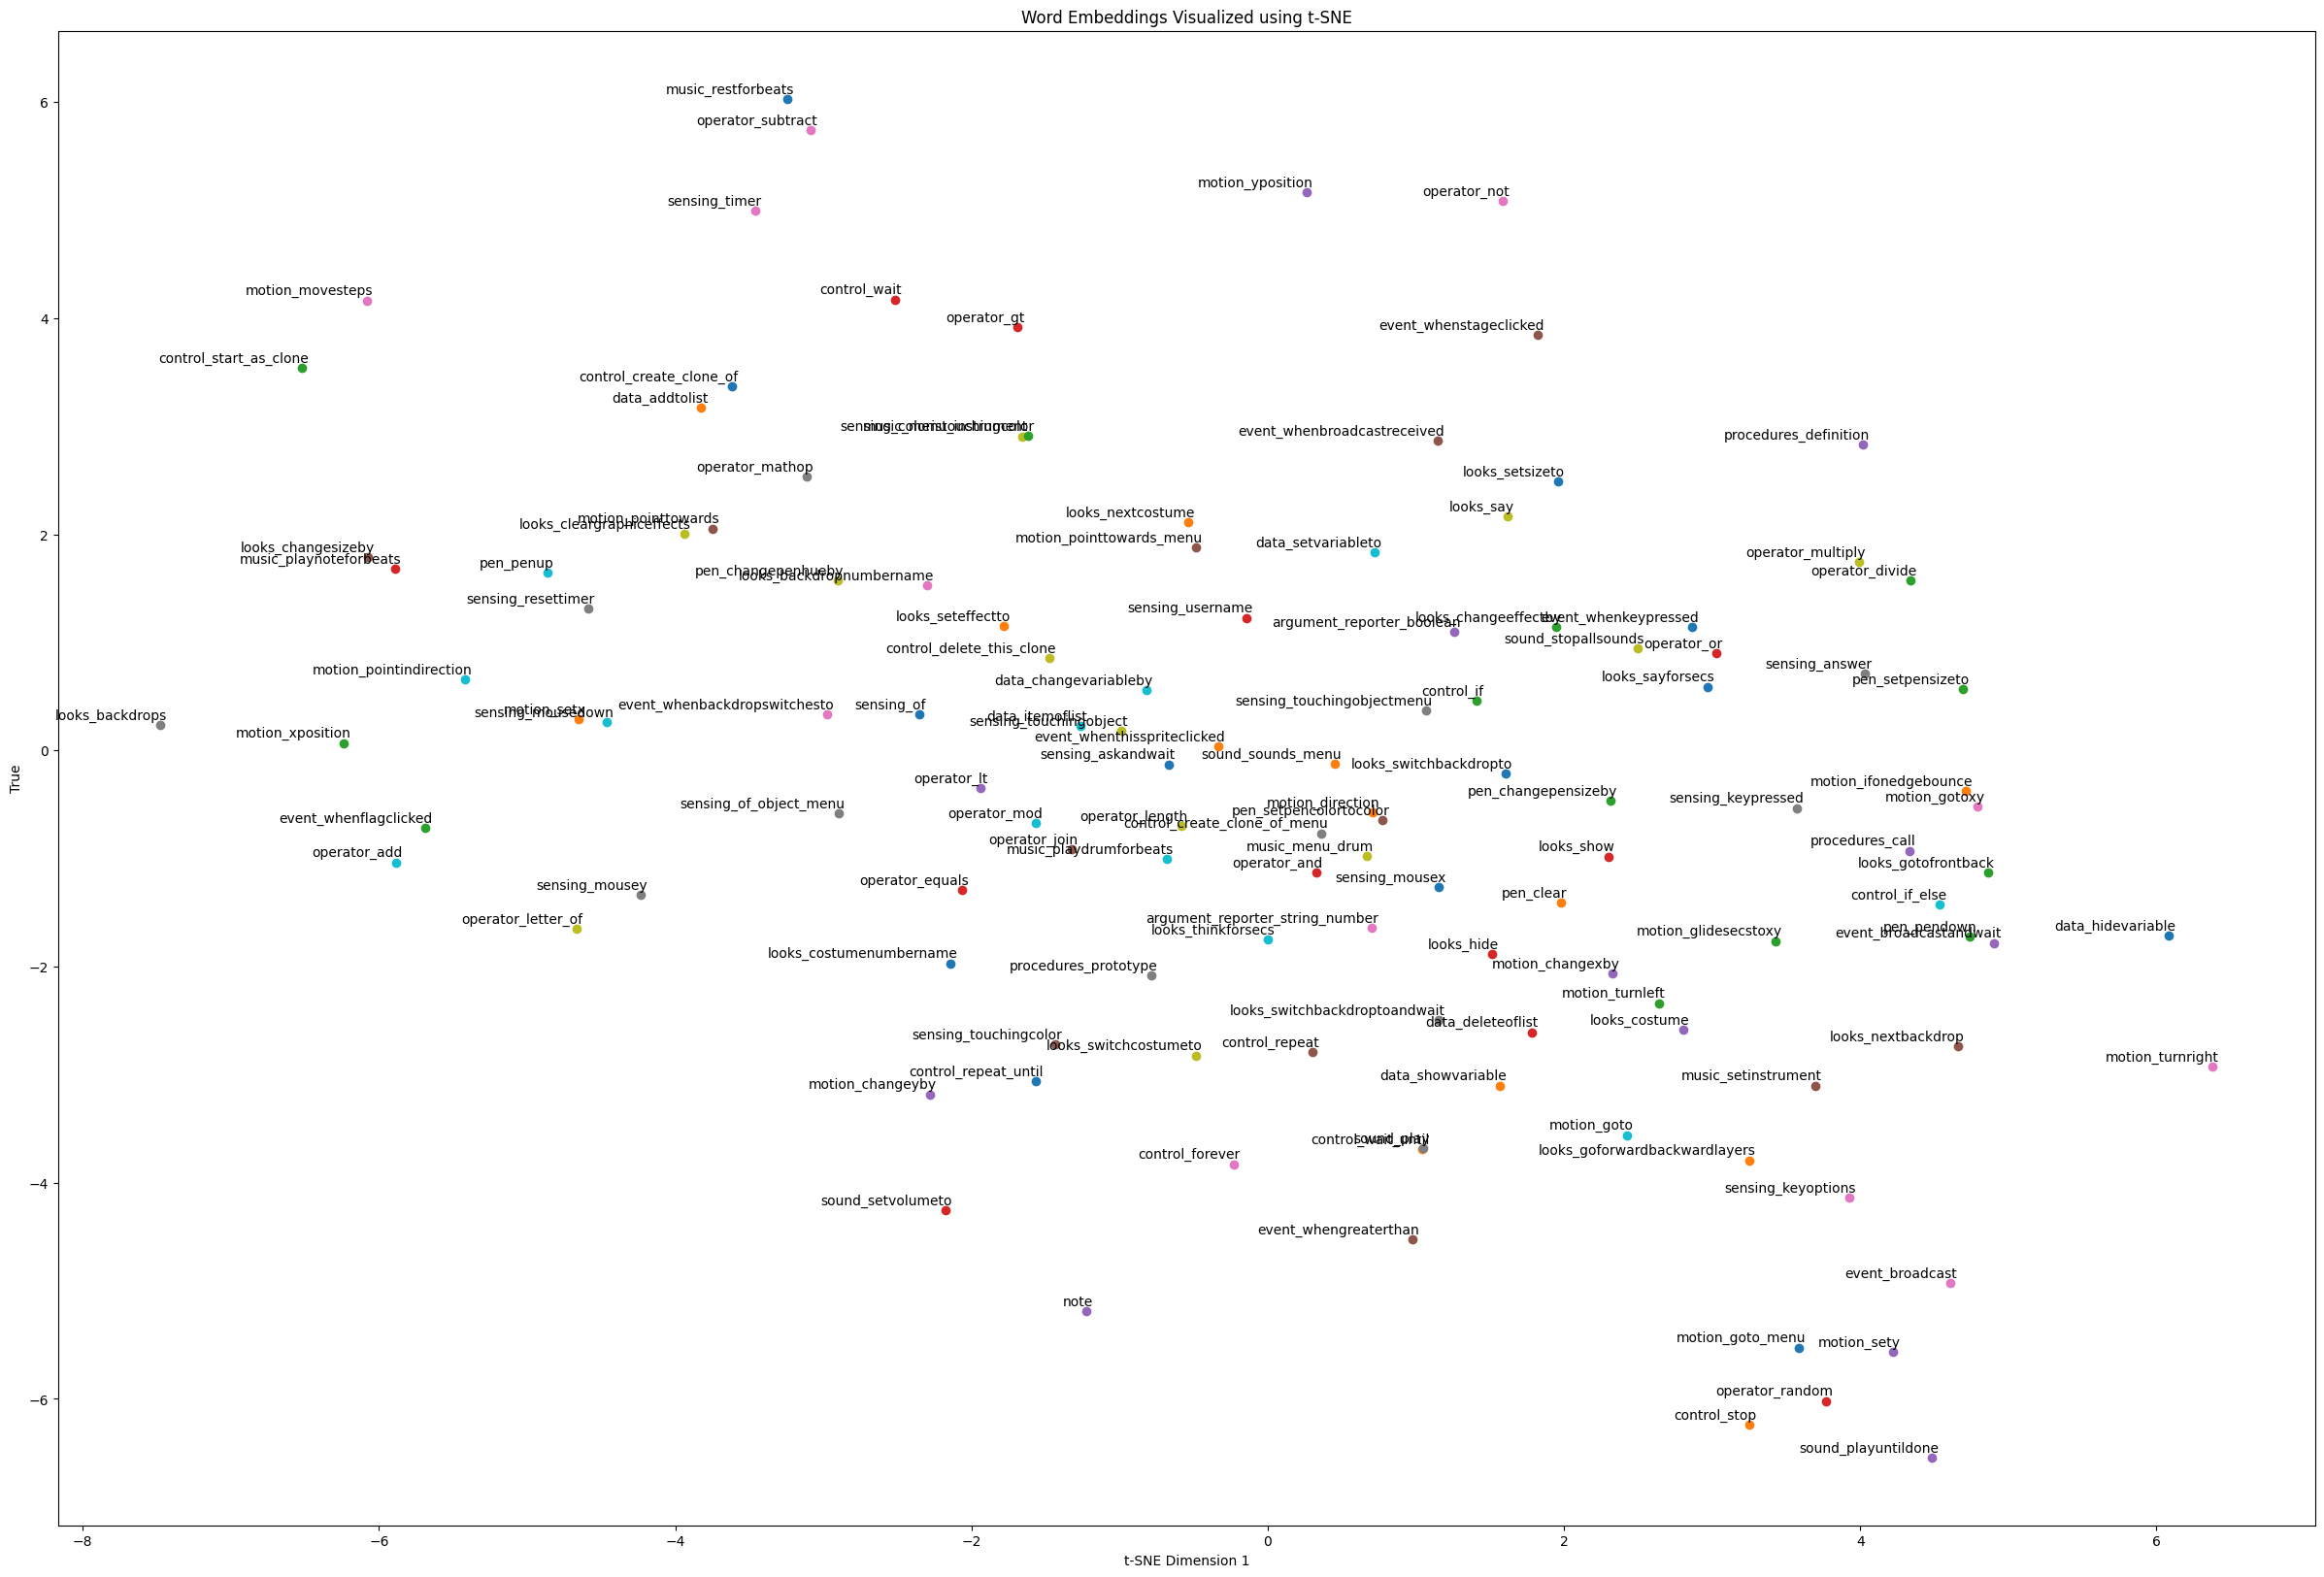

<Figure size 640x480 with 0 Axes>

In [24]:
embeddings = model.embed_layer.weight.detach().cpu().numpy()
plot_embeddings(embeddings, dataset.word2idx)

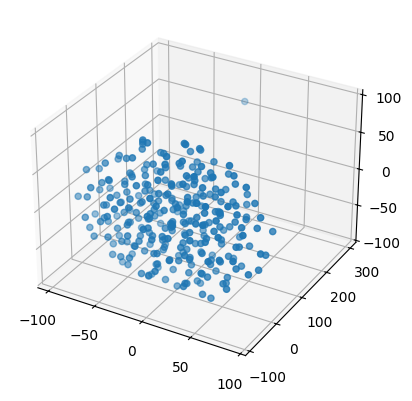

In [25]:
tsne = TSNE(n_components=3)
embeddings_3d = tsne.fit_transform(embeddings)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])
plt.show()

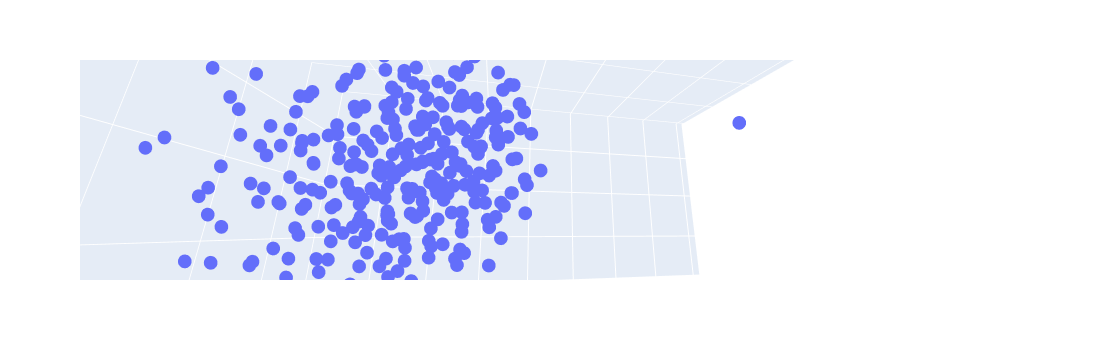

In [26]:
import plotly.express as px
import pandas as pd

# Suponiendo que tus embeddings están en la variable `embeddings`
df = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

## K-Means

In [27]:
from sklearn.preprocessing import normalize

# Because of the nature of the embeddings we have to normalize these before apply clutering
normalized_embeddings = normalize(embeddings, norm='l2')

mean = np.mean(normalized_embeddings, axis=0) # Mean of each column
std_dev = np.std(normalized_embeddings, axis=0)  # Std for each column
X_standardized = (normalized_embeddings - mean) / std_dev

In [28]:

k_values = range(1, 11)
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_standardized)
    wcss.append(kmeans.inertia_)  

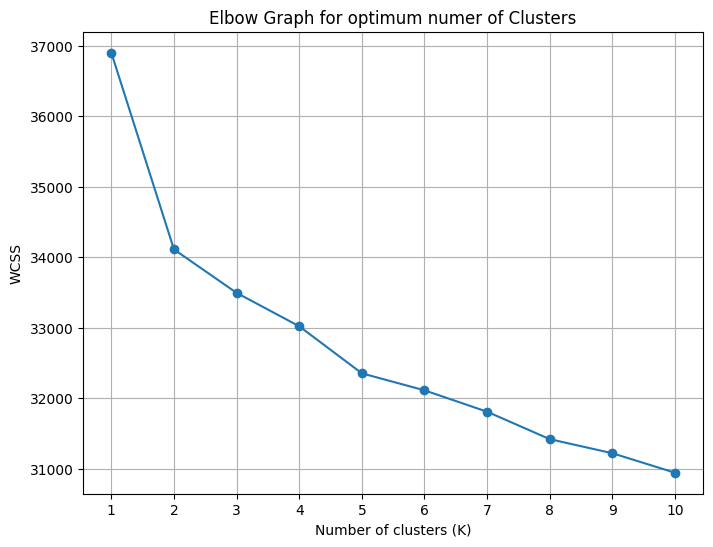

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Graph for optimum numer of Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [30]:
elbow_graph = {}
for idx, k in enumerate(k_values):
    elbow_graph[k] = wcss[idx]

In [31]:
print(elbow_graph)

{1: 36900.0, 2: 34109.640625, 3: 33493.16015625, 4: 33019.4453125, 5: 32351.5390625, 6: 32110.322265625, 7: 31806.99609375, 8: 31417.73046875, 9: 31217.8125, 10: 30941.388671875}


In [34]:


# I have selected k=5 clusters with the elbow graph
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_standardized)

# For each coordinate of points of embeddings we have a label for each one
labels = kmeans.labels_
print("Labels:", labels)

# Also we have the points
centroids = kmeans.cluster_centers_
print("Centroids:", centroids)

Labels: [0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0
 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1
 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1
 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0
 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0
 1 1 0 0]
Centroids: [[ 0.14404917  0.21776861  0.31286424  0.27715227  0.15172924  0.36645472
   0.4764474   0.23547858  0.31048968  0.40004995  0.10189261  0.3383972
   0.11418489  0.20271572  0.3431212   0.24855787  0.23932502  0.43167418
   0.00952173  0.25611407  0.13868532  0.05448603  0.3907195   0.3938022
   0.37453055  0.5093902   0.28691047  0.19831553  0.07460523  0.1933745
   0

### Evaluation of the cluster

In [35]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_standardized, labels)
print(f'Índice de Silueta: {silhouette_avg}')

Índice de Silueta: 0.06957187503576279
